This notebook simply trains models which will be used for XAI tasks later on.
- Train models without much hyperparameter tuning or optimization
- Show feature importance if model is self-explaining

In [126]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score, root_mean_squared_error
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

# Tree Visualisation
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus
import graphviz

# Neural Network (pytorch)
import torch
from torch import nn
from torch import optim

import joblib


# Display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [49]:
def classification_confusion_matrix(y_test, y_pred, labels = None):
    class_names=y_test.unique().tolist() # name  of classes
    print(f"y_test label order: {class_names}")
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred, labels=None)
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    print(classification_report(y_test, y_pred, target_names=labels))

# Load dataset from pickle

In [99]:
def load_split_show_df(df, y_label, test_split_size=0.2, is_classification = True):
    X, y = df.drop(columns=[y_label]), df[y_label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split_size, random_state=8, stratify=y if is_classification else None) # random_state for reproducibility 
    print(f"Total: {len(df)},Train size: {len(X_train)}, Test size ({y_label}): {len(y_test)}")
    display(df.head())
    return X_train, X_test, y_train, y_test

In [100]:
df_accident = pd.read_pickle('./data/processed/accident.pkl')
X_train_accident, X_test_accident, y_train_accident, y_test_accident = load_split_show_df(df_accident, "Survived", test_split_size=0.15)

df_iris = pd.read_pickle('./data/processed/iris.pkl')
X_train_iris, X_test_iris, y_train_iris, y_test_iris = load_split_show_df(df_iris, "label", test_split_size=0.15)

df_student = pd.read_pickle('./data/processed/student_performance.pkl')
X_train_student, X_test_student, y_train_student, y_test_student = load_split_show_df(df_student, "Performance Index", test_split_size=0.15, is_classification = False)

Total: 196,Train size: 166, Test size (Survived): 30


,Age,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived,Gender - isMale
0,56,27.0,0,0,1,0
1,69,46.0,0,1,1,0
2,46,46.0,1,1,0,1
3,32,117.0,0,1,0,1
4,60,40.0,1,1,0,0


Total: 3000,Train size: 2550, Test size (label): 450


,sepal length,sepal width,petal length,petal width,label
0,5.2,3.8,1.5,0.3,0
1,5.3,4.1,1.5,0.1,0
2,4.8,3.1,1.5,0.2,0
3,5.2,3.7,1.5,0.2,0
4,4.9,3.0,1.5,0.3,0


Total: 10000,Train size: 8500, Test size (Performance Index): 1500


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


# Logistic Regression - accident

In [85]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=8, solver='lbfgs') #, max_iter=500

# fit the model with data
logreg.fit(X_train_accident, y_train_accident)
print("Training Accuracy:", metrics.accuracy_score( y_train_accident, logreg.predict(X_train_accident)))

Training Accuracy: 0.5542168674698795


In [92]:
joblib.dump(logreg, "./models/accident_lr.pkl") 

['./models/accident_lr.pkl']

y_test label order: [1, 0]
Accuracy: 0.6333333333333333


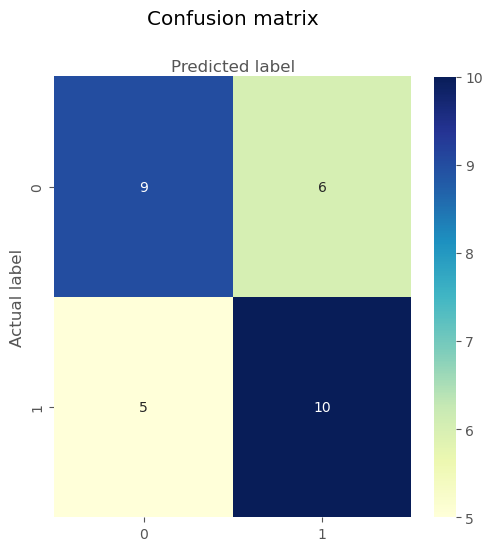

              precision    recall  f1-score   support

    Survived       0.64      0.60      0.62        15
        Died       0.62      0.67      0.65        15

    accuracy                           0.63        30
   macro avg       0.63      0.63      0.63        30
weighted avg       0.63      0.63      0.63        30



In [86]:
y_pred_accident = logreg.predict(X_test_accident)
classification_confusion_matrix(y_test_accident, y_pred_accident, labels = ["Survived","Died"])

Feature names: ['Age' 'Speed_of_Impact' 'Helmet_Used' 'Seatbelt_Used' 'Gender - isMale']


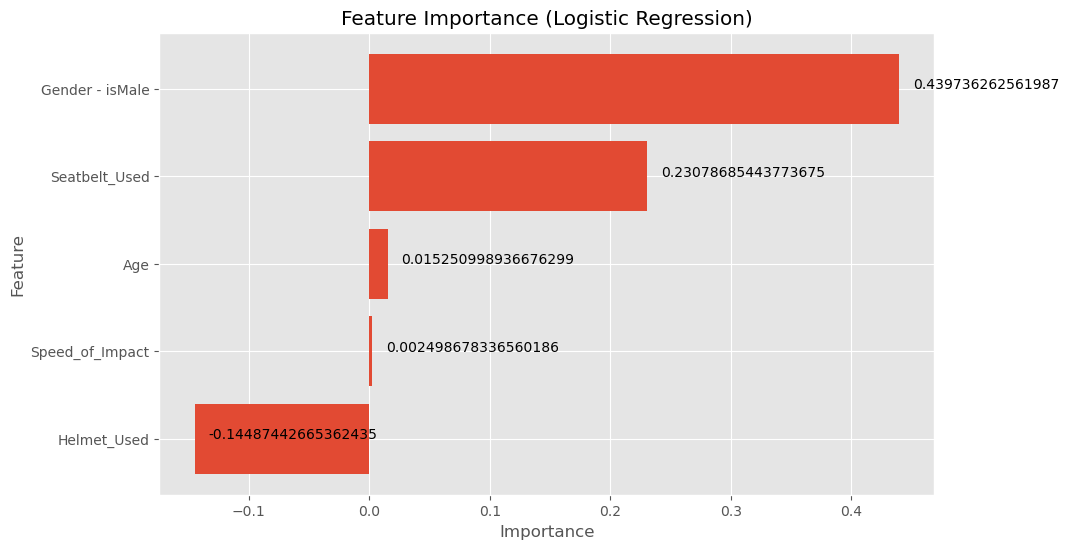

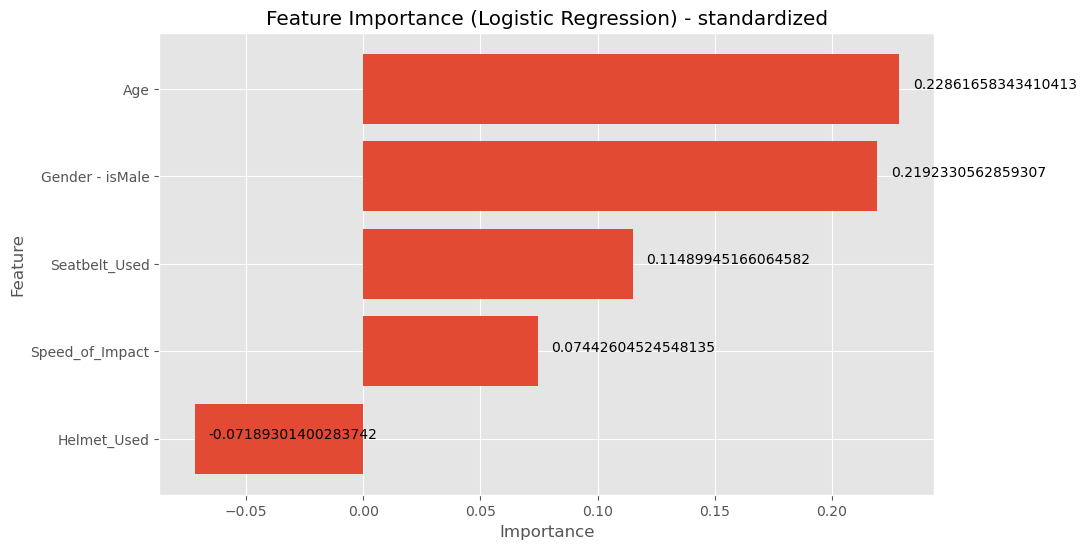

In [64]:
# Feature Importance
print("Feature names:", logreg.feature_names_in_)

# get importance
importance = logreg.coef_[0]
importance_standardized = importance * X_train_accident.std(axis=0).values

matplotlib.rc('figure', figsize=[5,5])
plt.style.use('ggplot')
# Plot feature importance
feature_importance = pd.DataFrame({
    'Feature': logreg.feature_names_in_,
    'Importance': importance
})
feature_importance = feature_importance.sort_values(by='Importance')
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
for i, value in enumerate(feature_importance["Importance"].to_list()):
    plt.annotate(value, (value, i), textcoords="offset points", xytext=(10,0), ha='left')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Logistic Regression)')
plt.show()

# Plot feature importance (standardized)
feature_importance = pd.DataFrame({
    'Feature': logreg.feature_names_in_,
    'Importance': importance_standardized
})
feature_importance = feature_importance.sort_values(by='Importance')
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
for i, value in enumerate(feature_importance["Importance"].to_list()):
    plt.annotate(value, (value, i), textcoords="offset points", xytext=(10,0), ha='left')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Logistic Regression) - standardized')
plt.show()

# Decision Tree - accident

In [84]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", random_state=2)

# Train Decision Tree Classifer
clf = clf.fit(X_train_accident,y_train_accident)

print("Training accuracy:",metrics.accuracy_score(y_train_accident,clf.predict(X_train_accident)))

#Predict the response for test dataset
y_pred_accident = clf.predict(X_test_accident)
print("Validation Accuracy:",metrics.accuracy_score(y_test_accident, y_pred_accident))

Training accuracy: 1.0
Validation Accuracy: 0.6


In [93]:
joblib.dump(clf, "./models/accident_dt.pkl") 

['./models/accident_dt.pkl']

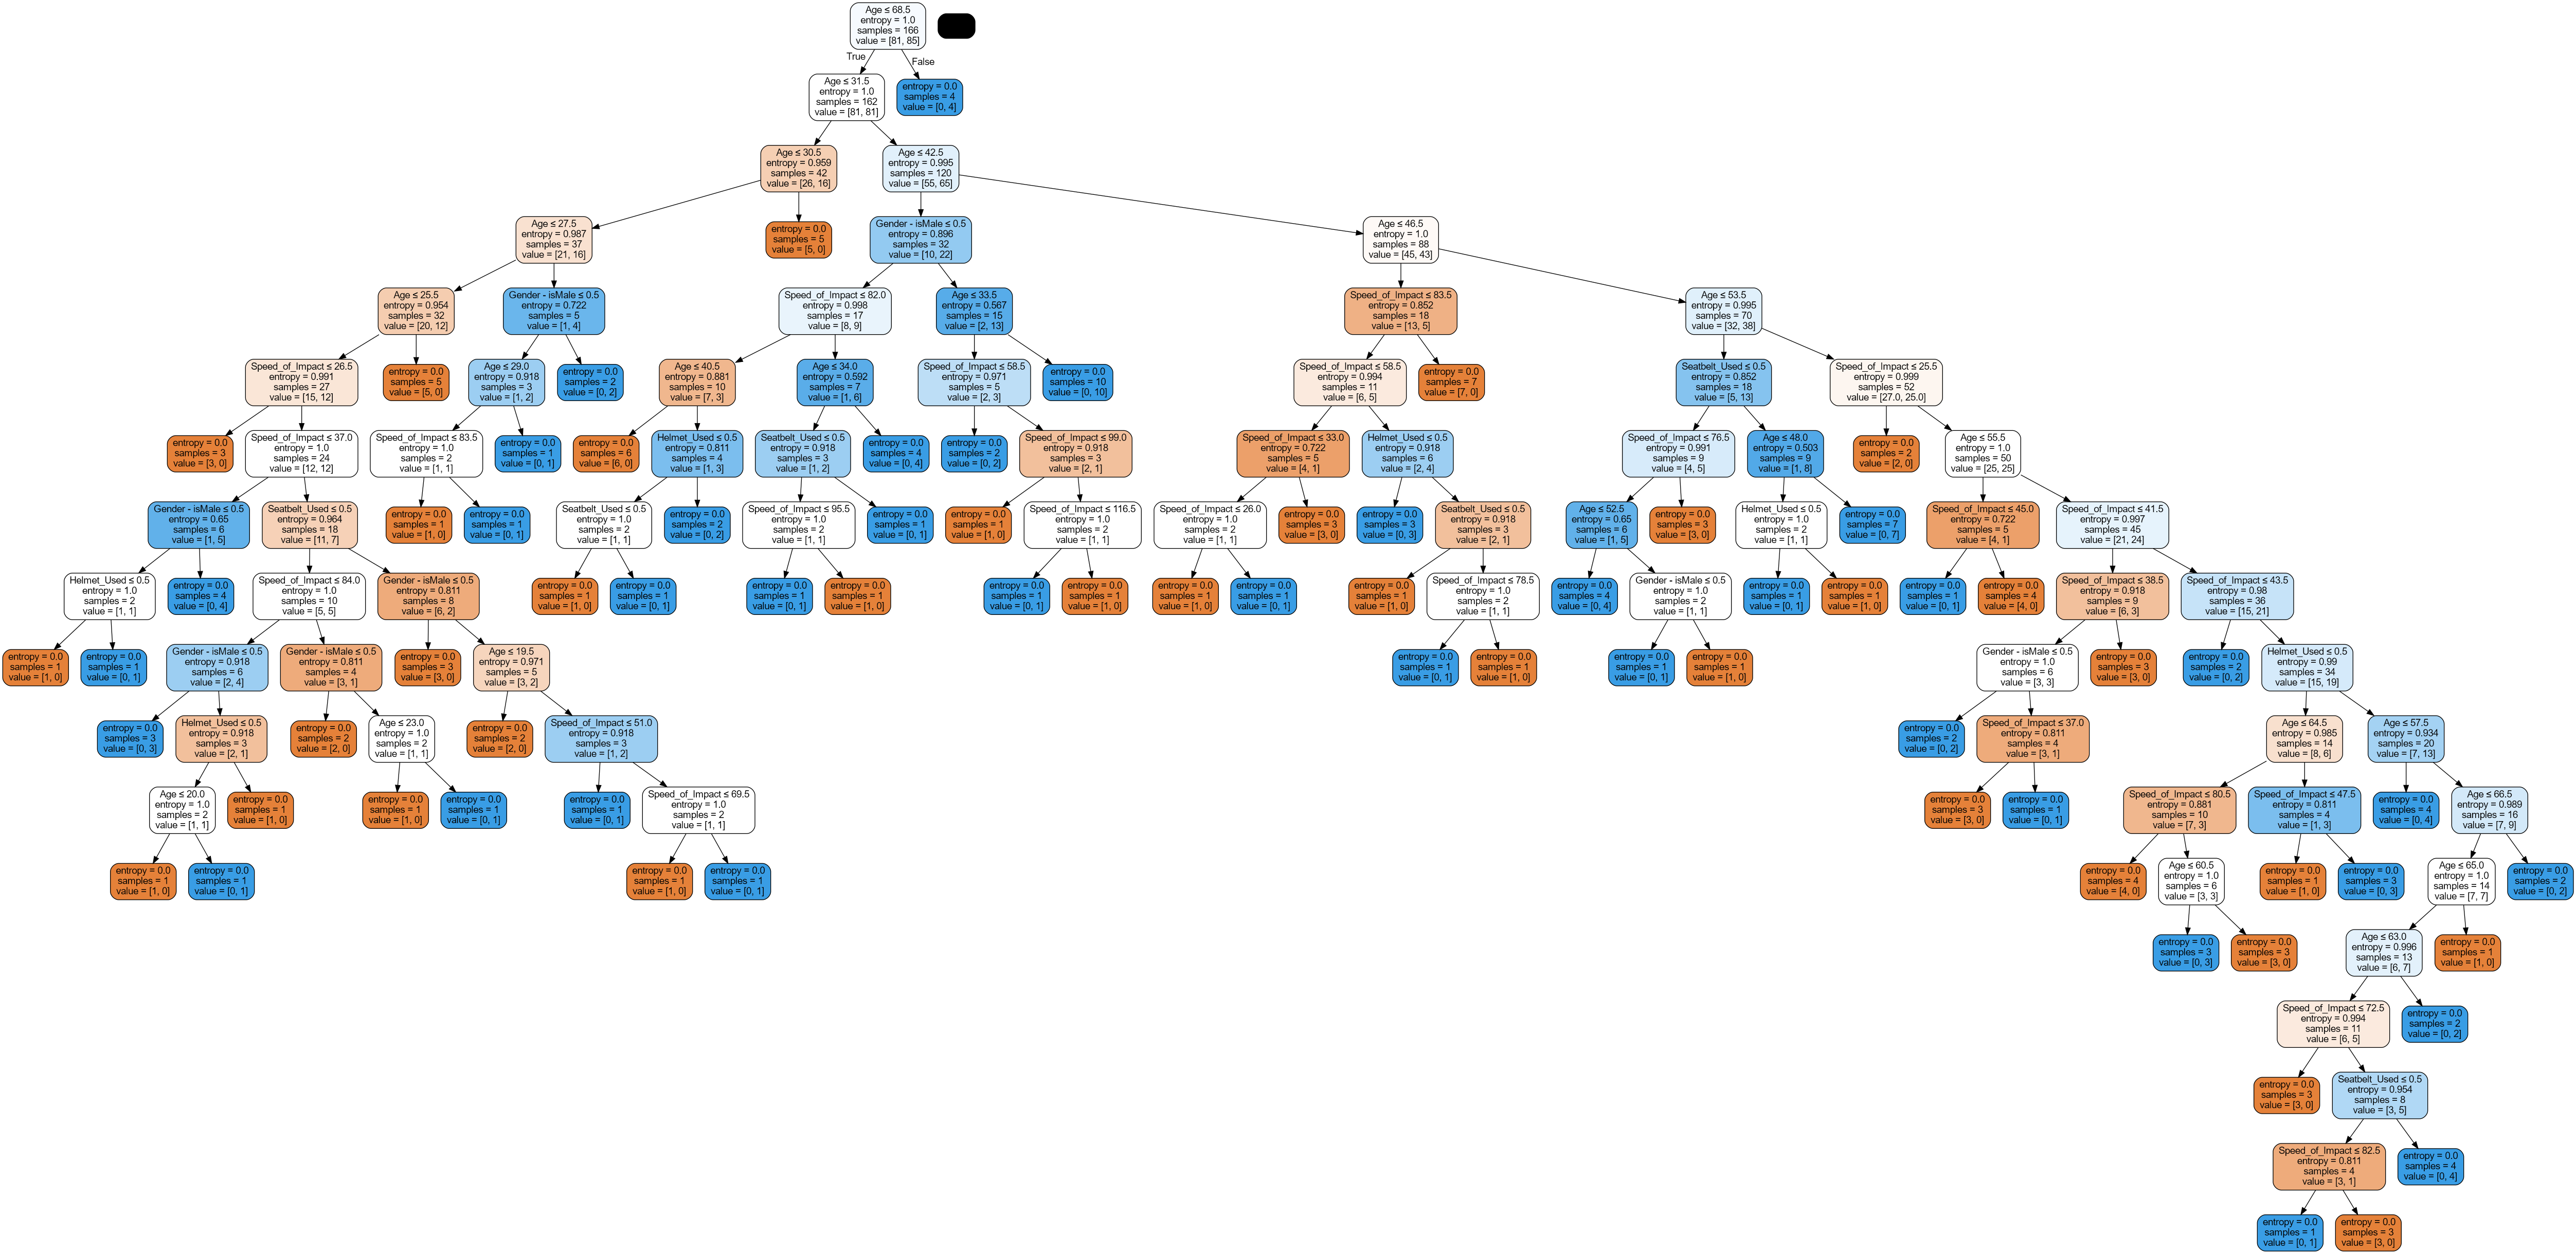

In [80]:
# Show decision tree
feature_cols = X_train_accident.columns.to_list()
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols) # , class_names=['0','1']
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('./static/accident.png')
Image(graph.create_png())

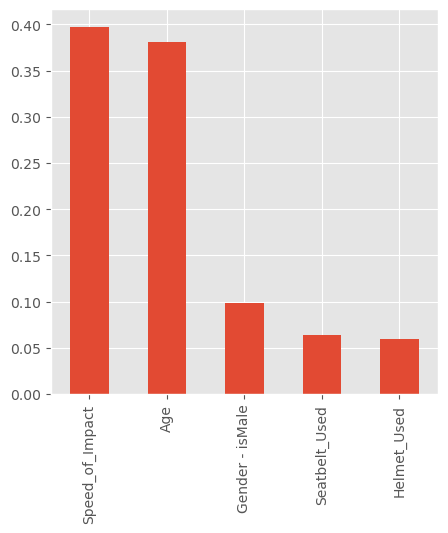

In [83]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(clf.feature_importances_, index=X_train_accident.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

# Random Forest - accident

In [87]:
rf = RandomForestClassifier()
rf.fit(X_train_accident, y_train_accident)
print("Training Accuracy:", metrics.accuracy_score(y_train_accident, rf.predict(X_train_accident)))

y_pred = rf.predict(X_test_accident)
accuracy = metrics.accuracy_score(y_test_accident, y_pred)
print("Validation Accuracy:", accuracy)

Training Accuracy: 1.0
Validation Accuracy: 0.6333333333333333


In [94]:
joblib.dump(rf, "./models/accident_rf.pkl") 

['./models/accident_rf.pkl']

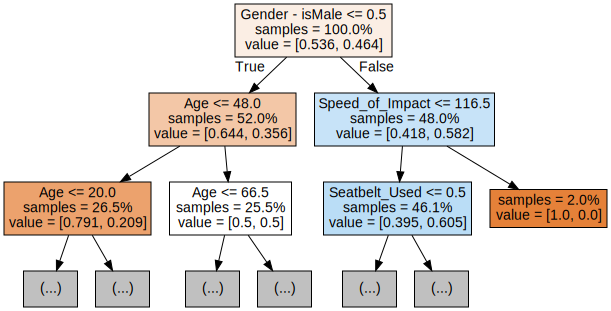

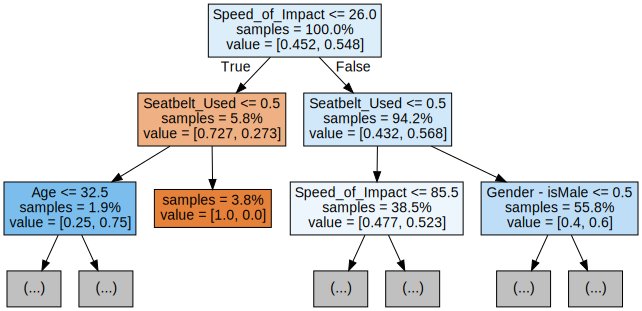

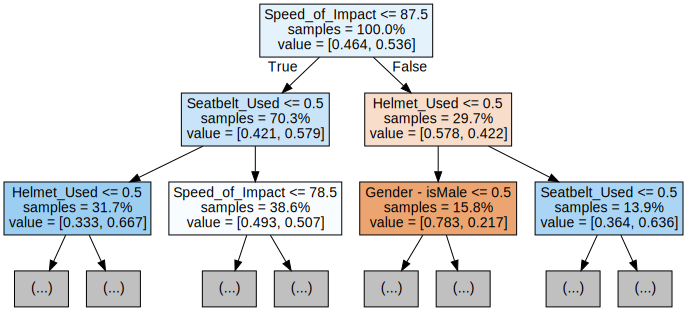

In [ ]:
# Show some of the underlying decision tree that made up of rf classifiers...
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train_accident.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

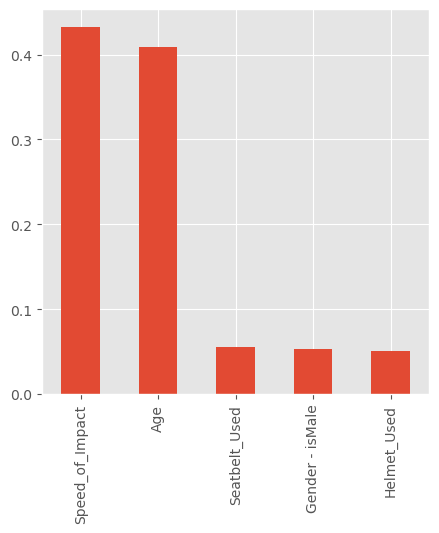

In [89]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf.feature_importances_, index=X_train_accident.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

# XGBoost - iris

In [104]:
xgb = XGBClassifier()
xgb.fit(X_train_iris,y_train_iris)

print("Training Accuracy:", metrics.accuracy_score(y_train_iris, xgb.predict(X_train_iris)))

y_pred = xgb.predict(X_test_iris)
accuracy = metrics.accuracy_score(y_test_iris, y_pred)
print("Validation Accuracy:", accuracy)

Training Accuracy: 1.0
Validation Accuracy: 1.0


In [105]:
joblib.dump(xgb, "./models/iris_xbg.pkl") 

['./models/iris_xbg.pkl']

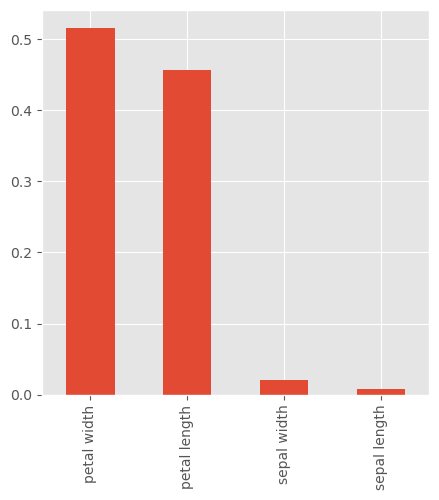

In [107]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(xgb.feature_importances_, index=xgb.feature_names_in_).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

# Neural Network (Simple) - student performance

In [114]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = self.relu1(self.hidden1(x))
        x = self.relu2(self.hidden2(x))
        x = self.output(x)
        return x


model = SimpleNN(len(X_train_student.columns), 8, 1)
print(model)

SimpleNN(
  (hidden1): Linear(in_features=5, out_features=8, bias=True)
  (relu1): ReLU()
  (hidden2): Linear(in_features=8, out_features=8, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=8, out_features=1, bias=True)
)


In [117]:
# Parameters
loss_fn   = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100
batch_size = 32

X = torch.tensor(X_train_student.values, dtype=torch.float32)
y = torch.tensor(y_train_student.values, dtype=torch.float32).reshape(-1, 1)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: torch.Size([8500, 5])
y shape: torch.Size([8500, 1])


In [118]:
# train the model
for epoch in range(n_epochs):
    running_loss = 0.
    running_count = 0
    model.train()
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        ybatch = y[i:i+batch_size]

        y_pred = model(Xbatch)
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_count += 1
    last_loss = running_loss / running_count
    print(f'Finished epoch {epoch}, loss {last_loss}')

Finished epoch 0, loss 1772.7894025816954
Finished epoch 1, loss 71.12767182256943
Finished epoch 2, loss 67.34319374973613
Finished epoch 3, loss 63.2804019253953
Finished epoch 4, loss 58.84797797525736
Finished epoch 5, loss 54.134281438096124
Finished epoch 6, loss 49.008403641836985
Finished epoch 7, loss 43.71550866894256
Finished epoch 8, loss 38.439375712459245
Finished epoch 9, loss 33.76320724917534
Finished epoch 10, loss 29.79740373711837
Finished epoch 11, loss 27.119075517009076
Finished epoch 12, loss 25.0011151643624
Finished epoch 13, loss 22.96087722491501
Finished epoch 14, loss 20.86501423039831
Finished epoch 15, loss 18.67389768944647
Finished epoch 16, loss 16.3852923830649
Finished epoch 17, loss 14.054437138980493
Finished epoch 18, loss 11.787902645598678
Finished epoch 19, loss 9.730010097188162
Finished epoch 20, loss 7.9869103844004465
Finished epoch 21, loss 6.656557639738671
Finished epoch 22, loss 5.722161787793152
Finished epoch 23, loss 5.1197492914988

In [128]:
# compute accuracy (no_grad is optional)
with torch.no_grad():
    y_train_pred = model(X)
    y_test_pred = model(torch.tensor(X_test_student.values, dtype=torch.float32))

# Training
print("Training (r2):", r2_score(y_train_student, y_train_pred))
print("Training (rmse):", root_mean_squared_error(y_train_student, y_train_pred))

# Validation
print("Validation (r2):", r2_score(y_test_student, y_test_pred))
print("Validation (rmse):", root_mean_squared_error(y_test_student, y_test_pred))

Training (r2): 0.9887328579529541
Training (rmse): 2.0400750067152793
Validation (r2): 0.9883494576316201
Validation (rmse): 2.068891434857377


In [134]:
torch.save(model, "./models/student_nn.pt")
# model_scripted = torch.jit.script(model)
# model_scripted.save("./models/student_nn.pt")

In [129]:
# torch.save({
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'epoch': epoch
#     }, "./models/student_nn.pt")